In [1]:
from __future__ import division
from functions2 import *
import numpy as np
import math
from scipy import optimize
import pylab as pl
from IPython import display as dp

# Model Parameters:

In [2]:
T = 5
time_step = 1/12
range_ = np.arange(time_step,T+time_step,time_step)
vol_window = 3000
term_window= 6000
interpol_method = 'spline' #NelsonSiegel

# Load historical rates

Total of nulls RIFLGFCM01_N.B    10505
RIFLGFCM03_N.B     5610
RIFLGFCM06_N.B     5610
RIFLGFCY01_N.B      627
RIFLGFCY02_N.B     4219
RIFLGFCY03_N.B      627
RIFLGFCY05_N.B      627
RIFLGFCY07_N.B     2497
RIFLGFCY10_N.B      627
RIFLGFCY20_N.B     8545
RIFLGFCY30_N.B     5391
dtype: int64

 Total of nulls 0


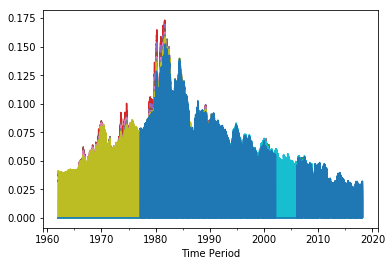

In [3]:
data,data_ = load_data()
data_.plot(legend=False);

In [4]:
data_.describe().T

,count,mean,std,min,25%,50%,75%,max
RIFLGFCM01_N.B,14648.0,0.003438,0.009859,0.0,0.0000,0.0000,0.000200,0.0527
RIFLGFCM03_N.B,14648.0,0.024658,0.031562,0.0,0.0000,0.0019,0.050900,0.1549
RIFLGFCM06_N.B,14648.0,0.025814,0.032749,0.0,0.0000,0.0036,0.052200,0.1567
RIFLGFCY01_N.B,14648.0,0.049706,0.034993,0.0,0.0215,0.0507,0.069600,0.1731
RIFLGFCY02_N.B,14648.0,0.038511,0.040236,0.0,0.0000,0.0274,0.064700,0.1695
RIFLGFCY03_N.B,14648.0,0.053818,0.033880,0.0,0.0293,0.0548,0.073725,0.1659
RIFLGFCY05_N.B,14648.0,0.056421,0.032627,0.0,0.0351,0.0565,0.076200,0.1627
RIFLGFCY07_N.B,14648.0,0.052373,0.037146,0.0,0.0206,0.0562,0.077100,0.1605
RIFLGFCY10_N.B,14648.0,0.059692,0.030774,0.0,0.0400,0.0583,0.077600,0.1584
RIFLGFCY20_N.B,14648.0,0.019807,0.025517,0.0,0.0000,0.0000,0.044900,0.0830


### Check for nans and zeros

In [5]:
(data_.isnull()).sum()

RIFLGFCM01_N.B    0
RIFLGFCM03_N.B    0
RIFLGFCM06_N.B    0
RIFLGFCY01_N.B    0
RIFLGFCY02_N.B    0
RIFLGFCY03_N.B    0
RIFLGFCY05_N.B    0
RIFLGFCY07_N.B    0
RIFLGFCY10_N.B    0
RIFLGFCY20_N.B    0
RIFLGFCY30_N.B    0
dtype: int64

In [6]:
(data_==0).sum()

RIFLGFCM01_N.B    10595
RIFLGFCM03_N.B     5629
RIFLGFCM06_N.B     5610
RIFLGFCY01_N.B      627
RIFLGFCY02_N.B     4219
RIFLGFCY03_N.B      627
RIFLGFCY05_N.B      627
RIFLGFCY07_N.B     2497
RIFLGFCY10_N.B      627
RIFLGFCY20_N.B     8545
RIFLGFCY30_N.B     5391
dtype: int64

In [7]:
(np.isfinite(data_)).sum()

RIFLGFCM01_N.B    14648
RIFLGFCM03_N.B    14648
RIFLGFCM06_N.B    14648
RIFLGFCY01_N.B    14648
RIFLGFCY02_N.B    14648
RIFLGFCY03_N.B    14648
RIFLGFCY05_N.B    14648
RIFLGFCY07_N.B    14648
RIFLGFCY10_N.B    14648
RIFLGFCY20_N.B    14648
RIFLGFCY30_N.B    14648
dtype: int64

# Build Term Structure using spline interpolation

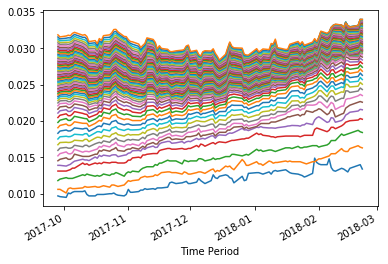

In [8]:
TS = BootStraper()
y = data_[-term_window:]
y=y[y!=0].dropna() #removing days in which yields where quoted as zero
x_= None
r = TS.BootStrap(x_,y,method=interpol_method)
r[-100:].plot(legend=False)

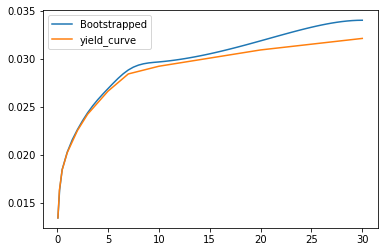

In [9]:
plt.plot(np.array(r.columns),r[-1:].as_matrix().flatten(),label='Bootstrapped');
plt.plot(TS.x,data_[-1:].as_matrix().flatten(),label='yield_curve');
plt.legend()

In [10]:
(r.isnull()).sum().sum()

20

In [11]:
r=r.dropna()

In [12]:
(r.isnull()).sum().sum()

0

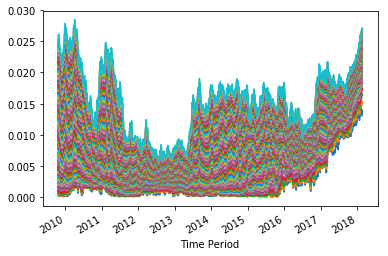

In [13]:
interpol = CubicS(x=np.array(r.columns),x_=range_)
f = interpol.spline
irs = pd.DataFrame(data=apply(f,r),index=r.index,columns=range_)
irs[-2000:].plot(legend=False);


# Volatility estimate

In [14]:
np.seterr(all='ignore') 
# it is expected to ger errors on the log because of
# divisions by zero. Those are removed from the data
# on the last lines
def get_vols(irs,vol_window):
    irs = irs[-vol_window:]
    ratio = irs[1:]/irs.shift(1)[1:]
    ratio = ratio[ratio.notnull()].copy()
    for i in ratio.columns:
        ratio = ratio[ratio[i].notnull()]
        log_ratio = np.log(ratio)
    log_ratio = log_ratio[log_ratio!=np.inf]
    log_ratio = log_ratio[log_ratio!=-np.inf]
    return np.std(log_ratio)

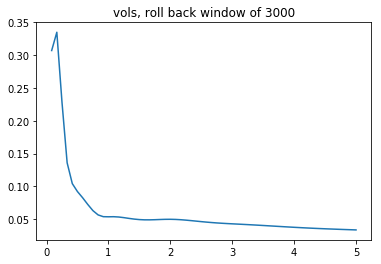

In [15]:
vols = get_vols(irs,vol_window)
plt.plot(vols)
plt.title('vols, roll back window of {}'.format(vol_window));

We also need mkt prices from the results obtained using the Nelson Siegel model within the TermStructure class

In [16]:
last_term = np.exp(-1*irs[-1:]*range_)


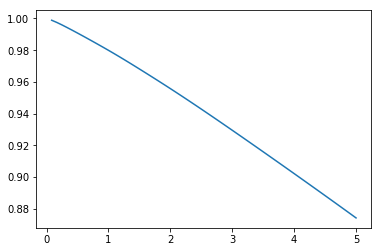

In [17]:
plt.plot(range_,last_term.as_matrix().flatten());

The market data dictionary is the main input to the oprimization process along with the model specification (Maturity and time step)

In [18]:
mkt_data = {'Price':last_term.as_matrix().flatten(),'Vol':list(vols*np.sqrt(time_step))}


# Short rate lattice and Tree classes

In [19]:
class short_rate_lattice():
    def __init__(self,T,time_step):
        self.time_step = time_step
        self.T=T
        self.n_of_periods = T/time_step
        self.time = np.arange(0,T,time_step)
        self.period = np.arange(int(self.n_of_periods))
        self.ir = np.random.rand(int(self.n_of_periods))
        self.sigma = np.random.rand(int(self.n_of_periods))
        self.sigma[0] = 0
        self.build_sr()
    def setup(self,ir,sigma):
        self.ir = ir
        self.sigma = sigma
        self.build_sr()
         
    def build_sr(self):
        self.sr_lattice = {}
        for i in self.period:            
            bin_ = self.ir[i]*np.exp(np.arange(i+1)*2*self.sigma[i])#*np.sqrt(self.time_step))
            self.sr_lattice[i]=bin_

In [20]:
class Tree():
    def __init__(self,T,srl):
        self.srl = srl
        self.T = T
        self.n_of_periods = srl.n_of_periods
        self.period = np.arange(T)+1
        self.tree = {} #new
        self.p = 0 #new
        self.vol = 0 #new
        
        
    def build(self):   
        self.tree = {}
        self.tree[self.T]=np.ones(self.T+1)
        for i in np.flip(self.period,axis=0):                    
            self.tree[i-1] = 0.5*(self.tree[i][:-1] + np.roll(self.tree[i],shift=-1)[:-1])*np.exp(-self.srl.sr_lattice[i-1])
        self.p = self.tree[0][0]
        self.get_vol()
        
        return self.p,self.vol
        
    def get_vol(self):
        
        if self.T !=1:
            rates = np.log(self.tree[1])/(self.T-1)
            self.vol = 0.5*np.log(rates[1]/rates[0])/np.sqrt(self.srl.time_step)
        else:
            self.vol = 0
        
        pass

# BDT class

In [113]:
import multiprocessing as mp

class BDT(Tree):
    def __init__(self,T,time_step,mkt_data,plot=0):
        self.loss_bin = []
        self.T=T
        self.time_step = time_step
        self.n_of_periods = T/time_step
        self.period = np.arange(int(self.n_of_periods))
        self.srl = short_rate_lattice(T,time_step)
        self.build_Trees()
        self.mkt_data = mkt_data
        self.random_seed()
        self.plot = plot
    
    def random_seed(self):
        self.ir = -1*np.log(self.mkt_data['Price'])/(np.arange(self.time_step,self.T+self.time_step,self.time_step))
        self.vols = np.array(self.mkt_data['Vol'])
        self.vols[0] = 0
        self.x0 = np.vstack([self.ir,self.vols])
    
    def build_Trees(self):
        trees_T = np.arange(int(self.n_of_periods))+1
        self.trees = {}
        self.tree_prices = []
        self.tree_vols = []        
        
        for i in trees_T:
            self.trees[i]= Tree(i,self.srl)
            
        pool = mp.Pool(processes=8)
        results = [pool.apply(self.trees[x].build) for x in trees_T]
        self.tree_prices,self.tree_vols = zip(*results)
        pool.close()

    @jit
    def loss(self,x,output=None):
        

        ir = x[:len(self.ir)]
        vols = np.append(0,x[len(self.ir):])
        self.srl.setup(ir,vols)
        self.build_Trees()      
        
        a = np.linalg.norm(np.array(self.tree_prices))
        b = np.linalg.norm(self.mkt_data['Price'])
        c = np.linalg.norm(np.array(self.tree_vols[1:]))
        d = np.linalg.norm(self.mkt_data['Vol'][1:])
       
        #ps = (np.array(self.tree_prices)/a - self.mkt_data['Price']/b)
        #vs = (np.array(self.tree_vols[1:])/c - self.mkt_data['Vol'][1:]/d)
        #ps[0] *= np.sqrt(0.1)
    
        ps = (np.array(self.tree_prices) - self.mkt_data['Price'])
        vs = (np.array(self.tree_vols[1:]) - self.mkt_data['Vol'][1:])
        ps[0] *= np.sqrt(0.1)

        loss = np.append(ps,vs)
        
        loss = 10000000*loss.dot(loss)

        if self.plot== 1:
            self.plot_ps(self.tree_prices,self.tree_vols,loss)

        if math.isnan(loss):
            loss = 10**6
        

        return loss
    
    def plot_loss(self,loss):
        pl.title('Total loss')
        pl.plot(loss)
        dp.clear_output(wait=True)
        dp.display(pl.gcf())
        
    
    def plot_ps(self,p,v,loss):
        print(loss)
        N = np.arange(len(p))
        pindex = np.array(p)/np.array(self.mkt_data['Price'])
        vindex = np.array(v)/self.mkt_data['Vol']
        
        
        pl.title('Relatives price and vol')
        pl.plot(N,pindex,label='price')
        pl.plot(N[1:],vindex[1:],label='vol')
        plt.legend()
        
        dp.display(pl.gcf())
        dp.clear_output(wait=True)
        pl.gcf().clear()
        
    

# Model optimization:

# ADAM solver:
The class ADAMSolver is a full implementation of the AGAM solver, and it does the job of computing the numerical gradient, and updating the solution over a given number of iterations. A lot could be done to imporve the control over class, such as applying rules to stop the solution as it goes. Feel free to do it if you like. This online lecture was my main reference for implementing this solver: http://cs231n.stanford.edu/


The gradient of the loss function is obtained numerically (NumericalGradient). An of-the-shelf solver could do the work, but the benefit of having an implementation is that it allows to debug the code with more clarity. 

- Learning rate with exponential decay
- Lower cap at 5e-4
- At each iteration the absolute value of the next x is passed to avoid nulls/infs

First we will choose between paralel processing or not to solve for the gradient of the loss function numerically:

## Numerical Gradient with no subprocessing

In [115]:
def NumericalGradient(obj,x0,step):
    start = time.time()
    delta = np.zeros(x0.shape[0])    
    grad = []
    for i in np.arange(x0.shape[0]):
        delta[i] = step
        x2 = x0 + delta
        x1 = x0 - delta
        increment2 = obj.loss(x2)
        increment1 = obj.loss(x1)
        grad.append((increment2-increment1)/(2*step))
        delta[i] -= step    
    end = time.time()
    print("Gradient execution time: {}".format(end-start))

    return np.array(grad)


## Numerical Gradient wth Multiprocessing:

In [125]:
bdt = BDT(T,time_step,mkt_data,plot=0)
bdt.random_seed()

bdt.srl.setup(bdt.ir,bdt.vols)
x0 = np.append(bdt.ir,bdt.vols[1:])

In [116]:
import multiprocessing.pool as mpp
'''https://stackoverflow.com/questions/6974695/python-process-pool-non-daemonic'''
class NoDaemonProcess(mp.Process):
    # make 'daemon' attribute always return False
    def _get_daemon(self):
        return False
    def _set_daemon(self, value):
        pass
    daemon = property(_get_daemon, _set_daemon)

# We sub-class multiprocessing.pool.Pool instead of multiprocessing.Pool
# because the latter is only a wrapper function, not a proper class.
class MyPool(mpp.Pool):
    Process = NoDaemonProcess
    
def mpPool(obj,x):
    start = time.time()
    pool = MyPool(processes = 8)
    results = [pool.apply(obj.loss,args=(x[:,i],)) for i in np.arange(x.shape[1])]
    pool.close()
    pool.join()
    end = time.time()
    print("Gradient execution time: {}".format(end-start))
    return results

In [196]:
import multiprocessing.pool as mp
np.seterr(divide='ignore', invalid='ignore')

def f1(i,x0,obj,step):
    delta = np.zeros(x0.shape[0])    
    grad = np.zeros(x0.shape[0]) 
    #obj = bdt
    #step = 1e-3
    delta[i] = step
    x2 = x0 + delta
    x1 = x0 - delta
    increment2 = obj.loss(x2)
    increment1 = obj.loss(x1)
    return (increment2-increment1)/(2*step)

def NumericalGradient2(obj,x0,step):
    start = time.time()
    pool = MyPool(processes = 8)
    results = [pool.apply(f1,args=(i,x0,obj,step,)) for i in np.arange(x0.shape[0])]
    pool.close()
    pool.join()
    end = time.time()
    print("Gradient execution time: {}".format(end-start))
    return results

## Comparative performance

In [197]:
grad1 = NumericalGradient1(obj=bdt,x0=x0,step=step)

Gradient execution time: 47.629563331604004


In [198]:
grad2 = NumericalGradient2(bdt,x0,step)

Gradient execution time: 40.47234630584717


Gain of 8 seconds... ok, good.

## Let's implement a dropout
To randomly choose a fraction of the input vector to calculate the gradient. It could reduce accuracy but improve processing time considerably. Given that this model for a monthly rate will be computationally expensive, the trade-off might be beneficial.

In [199]:
def NumericalGradient3(obj,x0,step,drop):
    start = time.time()
    delta = np.zeros(x0.shape[0])    
    grad = np.zeros(x0.shape[0]) 
    indexes = np.arange(x0.shape[0])
    for i in np.random.choice(indexes,round(drop*x0.shape[0])):
        delta[i] = step
        x2 = x0 + delta
        x1 = x0 - delta
        increment2 = obj.loss(x2)
        increment1 = obj.loss(x1)
        grad[i]=(increment2-increment1)/(2*step)
        delta[i] -= step    
    end = time.time()
    print("Gradient execution time: {}".format(end-start))
    return np.array(grad)

In [200]:
def f2(i,x0,obj,step):
    delta = np.zeros(x0.shape[0])    
    grad = np.zeros(x0.shape[0]) 
    #obj = bdt
    #step = 1e-3
    delta[i] = step
    x2 = x0 + delta
    x1 = x0 - delta
    increment2 = obj.loss(x2)
    increment1 = obj.loss(x1)
    return i,(increment2-increment1)/(2*step)

def NumericalGradient4(obj,x0,step,drop):
    grad = np.zeros(x0.shape[0]) 
    indexes = np.arange(x0.shape[0])
    start = time.time()
    pool = MyPool(processes = 8)
    results = [pool.apply(f2,args=(i,x0,obj,step,)) for i in np.random.choice(indexes,round(drop*x0.shape[0]))]
    pool.close()
    pool.join()
    end = time.time()
    for i in results:
        grad[i[0]]=i[1]
    print("Gradient execution time: {}".format(end-start))
    return np.array(grad)

In [201]:
grad3 = NumericalGradient3(bdt,x0,step,drop=0.3)

Gradient execution time: 14.556249618530273


In [202]:
grad4 = NumericalGradient4(bdt,x0,step,drop=0.3)

Gradient execution time: 12.160581827163696


Ok, gradient 4 perform slighly better than gradient 3. For higher drop rates, gradient 4 will do even better... so lets keep 4 in the ADAMSolver class.

In [248]:
class ADAMSolver():
    def __init__(self):
        self.loss_bin = []
        self.drop = 0.3

    def plot_loss(self,loss,obj):
        p = obj.tree_prices
        v = obj.tree_vols
        pl.subplot(121)
        pl.title('Total loss')
        pl.plot(loss)

        N = np.arange(len(p))
        pindex = np.array(p)/np.array(obj.mkt_data['Price'])
        vindex = np.array(v)/obj.mkt_data['Vol']
        
        pl.subplot(122)
        pl.title('Relatives price and vol')
        pl.plot(N,pindex,label='price')
        pl.plot(N[1:],vindex[1:],label='vol')
        pl.legend()
        
        
        dp.clear_output(wait=True)
        dp.display(pl.gcf())
        pl.gcf().clear()
        time.sleep(1.0)
    
    def solve(self,obj,x0,lr=1e-3,step=1e-3,beta1=0.95,beta2=0.99,num_iter=1000):
        try:
            while True: 
                
                x0_=x0
                x_ = np.zeros(x0.shape[0])
                lossx_ = 0
                cache=0
                m = np.zeros(x0.shape[0])
                v = np.zeros(x0.shape[0])
                loss_bin = []
                for j in np.arange(num_iter):
                    start = time.time()
                    print('learning rate: {}'.format(lr))

                    grad =NumericalGradient4(obj,x0,step,self.drop)

                    m = beta1*m + (1-beta1)*grad
                    v = beta2*v + (1-beta2)*(grad**2)
                    mub = m/(1-beta1**(j+1))
                    vub = v/(1-beta2**(j+1))

                    ml,vl = (np.linalg.norm(m),np.linalg.norm(v))/(np.linalg.norm(m)+np.linalg.norm(v))
                    print('1sr moment level: {}'.format(ml))
                    print('2nd moment level: {}'.format(vl))

                    x0 += -lr*m/(np.sqrt(v)+1e-4) 


                    lossx0 = bdt.loss(x0)
                    print('current loss: {}'.format(round(lossx0,2)))

                    if j>0:     
                        print('loss reduction: {}%'.format(100*round(-1+lossx0/loss_bin[0],2)))
                        print('change in x: {}%'.format(100*np.linalg.norm(x0-x0_)))

                    #lr *= np.exp(-.0001*j)

                    if lossx0<cache:
                        x_ = x0
                        lossx_ = lossx0
    
                    if lr<5e-4:
                        lr=5e-6
                        step = 1e-3
                        #self.drop = 0.5

                    

                    if np.isnan(lossx0):
                        print('Gotcha')
                        x0 = cache
                        lr *=1e-5

                    x0 = np.absolute(x0)
                    loss_bin.append(lossx0)
                    cache = lossx0
                    x_=x0
                    end = time.time()
                    if j%5==0:
                        self.plot_loss(loss_bin,obj)

                    print('Iteration execution time: {}'.format(end-start))
                    print('Expected execution time (min): {}'.format((num_iter-j)*(end-start)/60))
                    print('Finished step {}'.format(j))
                    print('----------------------------------------------------------')
        except KeyboardInterrupt:
            return obj,(x0,lossx0),loss_bin,(x_,lossx_)
        
        return {obj,(x0,lossx0),loss_bin,(x_,lossx_)}


The key option plot in the class BDT will trigger a plot of the ratio of prices (model/market) and volatilities. It is a good way to visualize the work of the solver, however, it will shutdown the printed information, which is more usefull while selecting parameters.

In [245]:
bdt = BDT(T,time_step,mkt_data,plot=0)
bdt.random_seed()

bdt.srl.setup(bdt.ir,bdt.vols)
x0 = np.append(bdt.ir,bdt.vols[1:])

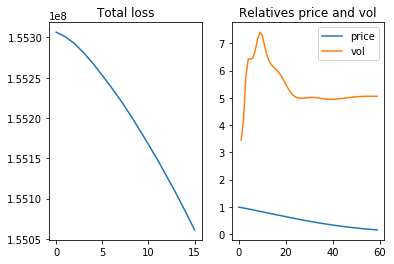

Iteration execution time: 5.006085634231567
Expected execution time (min): 82.18323916196823
Finished step 15
----------------------------------------------------------
learning rate: 5e-06


In [ ]:
solver = ADAMSolver()
solver.drop=.1
results = solver.solve(bdt,x0,lr=1e-6,step=1e-3,beta1=0.95,beta2=0.99,num_iter=1000)

# Ratio between model and market prices (~1)

In [ ]:
plt.plot(bdt.tree_prices,linestyle='-');
plt.plot(last_term.as_matrix().flatten(),linestyle='-.');

In [ ]:
plt.plot(bdt.tree_vols[1:],linestyle='-');
plt.plot(mkt_data['Vol'][1:],linestyle='-.');

# Lets save these results
To use them for pricing at another notebook

In [ ]:
import pickle

In [ ]:
pickle.dump(bdt,open( "bdt6_12.p", "wb" ))

Code to load data using pickle: <br>saved = pickle.load(open( "bdt.p", "rb" ) )

#  Value an Option with maturity t on a Bond with maturity T
On the underlying bond with maturity T. The option can be european, american and either call or put.

In [ ]:
from __future__ import division
from functions2 import *
import numpy as np
import math
from scipy import optimize
import pylab as pl
from IPython import display as dp
import pickle

In [ ]:
T = 5
time_step = 6/12
range_ = np.arange(time_step,T+time_step,time_step)

In [ ]:
bdt = pickle.load(open('bdt.p','rb'))

In [ ]:
srl = bdt.srl
sr_lattice = bdt.srl.sr_lattice

In [ ]:
def get_option(option,time_step,T,t,X,obj):
    
    if option[0]=='american':
        f = np.maximum
        
    if option[0] == 'european':
        f = lambda a,b: a
    
    if option[1] == 'call':
        g = lambda a,b: a-b
        
    if option[1] == 'put':
        g = lambda a,b: b-a
        
    N = int(T/time_step)
    n = int(t/time_step)
        
    obj.trees[N].build()
    Underlying_Bond = obj.trees[N].tree
    bond_value_at_n = np.array(Underlying_Bond[n])
    
    option_period = np.arange(n)+1

    Option_tree = {}
    Option_tree[n]=np.maximum(g(bond_value_at_n,X),0)

    for i in np.flip(option_period,axis=0):                    
        Option_tree[i-1] = 0.5*(Option_tree[i][:-1] + np.roll(Option_tree[i],shift=-1)[:-1])*np.exp(-obj.srl.sr_lattice[i-1])
    
        Option_tree[i-1] = f(Option_tree[i-1],f(g(Underlying_Bond[i-1],X),0))
   
        
    p = Option_tree[0][0]
    return p,Option_tree

American call with 4 years to maturity, on an underlying bond with maturity T. The option has a strike of \$0.8 per $1 of face value.

In [ ]:
option_p,option_tree = get_option(['american','call'],time_step,T,4,.8,bdt) 

In [ ]:
print('Price per 100$ FV: {}'.format(option_p*100))

In [ ]:
price = []
for i in np.arange(5)+1:
    p,_ = get_option(['american','call'],time_step,T,i,.8,bdt) 
    price.append(p)
plt.plot(np.arange(5)+1,price)

# Value a callable/putable bond:
Assumption: Coupons are paid at each time_step

In [ ]:
def callable_puttable_bond(bond,CPN,time_step,T,X,bdt):
    F = 1 # facevalue
    N = int(T/time_step)  

    if bond == 'callable':
        f = np.minimum      
        option = ['european','call']
        
    if bond == 'puttable':
        f = np.maximum
        option = ['european','put']
    
    '''Calculate Coupon Cash Flows'''
    C = {}
    for i in np.arange(N)+1:
        C[i] = CPN*F*time_step
   
    '''Build Bond Tree'''
    bond_period = np.arange(N-1)+1
    Bond_tree = {}
    Bond_tree[N]= (F+C[N])*np.ones(N+1)
    Bond_tree[N-1] = 0.5*(Bond_tree[N][:-1] + np.roll(Bond_tree[N],shift=-1)[:-1])*np.exp(-srl.sr_lattice[N-1])
    
    for i in np.flip(bond_period,axis=0):
        CP,_ = get_option(option,time_step,T,i*time_step,X,bdt)
        a = f(Bond_tree[i][:-1],CP)
        b = f(np.roll(Bond_tree[i],shift=-1)[:-1],CP)
        Bond_tree[i-1] = 0.5*(a + b + 2*C[i])*np.exp(-srl.sr_lattice[i-1])

    p_bond = Bond_tree[0][0]
    return p_bond,Bond_tree

Putable bond with CPN = 3% and 4 years to maturity and strike of \$0.9 per $1 FV

In [ ]:
p,Bond_tree = callable_puttable_bond('puttable',0.03,time_step,4,.9,bdt)

In [ ]:
print('Price per 100$ FV : {}:'.format(100*p))